## Machine Learning Commute Model
### Created by Chris Brunet

In [1]:
import requests
import urllib3
import pandas as pd
import numpy as np
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Step 1: Loading and Processing Strava Commute Data

In [2]:
def request_access_token(client_id, client_secret, refresh_token):
    """
    Post request to refresh and get new API access token

    Parameters:
        client_id: string
        client_secret: string
        refresh_token: string
    
    Returns:
        access_token: string
    """
    auth_url = "https://www.strava.com/oauth/token"
    payload = {
        'client_id': client_id,
        'client_secret': client_secret,
        'refresh_token': refresh_token,
        'grant_type': 'refresh_token',
        'f': 'json'
    }
    print("\nRequesting Access Token...")
    res = requests.post(auth_url, data=payload, verify=False)
    access_token = res.json()['access_token']
    print(f"\nAccess Token = {access_token}")
    return access_token

In [3]:
def get_activity_data(access_token):
    """
    Get request for Strava user activity data 

    Parameters:
        client_id: string
        client_secret: string
        refresh_token: string
    
    Returns:
        all_activities_df: DataFrame
        all_activities_list: list
    """
    print("\nGetting Activity Data...")
    activities_url = "https://www.strava.com/api/v3/athlete/activities"
    header = {'Authorization': 'Bearer ' + access_token}
    request_page_num = 1
    all_activities_list = []
    
    while True: # since max 200 activities can be accessed per request, while loop runs until all activities are loaded
        param = {'per_page': 200, 'page': request_page_num}
        get_activities = requests.get(activities_url, headers=header,params=param).json()
        if len(get_activities) == 0: # exit condition
            break
        all_activities_list.extend(get_activities)
        print(f'\t- Activities: {len(all_activities_list) - len(get_activities)} to {len(all_activities_list)}')
        request_page_num += 1
    
    all_activities_df = pd.DataFrame(all_activities_list)
    return all_activities_df

In [4]:
# Constant variables  
client_id = '111595'
client_secret = '8e8f246270159ece4b0eb3c75e494241bad86027'
refresh_token = '8285947a1614c22ebf0a7308cafb267ed4d9426f'

# API requests, getting and formatting Activity data and Segment data from Strava API
access_token = request_access_token(client_id, client_secret, refresh_token) # int
all_activities = get_activity_data(access_token) # DataFrame


Requesting Access Token...

Access Token = 7fe6df5180ce3d7d70796fdc99fb4645e4e029b6

Getting Activity Data...
	- Activities: 0 to 200
	- Activities: 200 to 326


In [5]:
# creating commute dataframe to only include activities labeled as 'commute'
all_commutes = all_activities[all_activities['commute'] == True]
all_commutes

resource_state                                athlete  \
2                 2  {'id': 54754532, 'resource_state': 1}   
3                 2  {'id': 54754532, 'resource_state': 1}   
4                 2  {'id': 54754532, 'resource_state': 1}   
5                 2  {'id': 54754532, 'resource_state': 1}   
6                 2  {'id': 54754532, 'resource_state': 1}   
..              ...                                    ...   
181               2  {'id': 54754532, 'resource_state': 1}   
182               2  {'id': 54754532, 'resource_state': 1}   
183               2  {'id': 54754532, 'resource_state': 1}   
184               2  {'id': 54754532, 'resource_state': 1}   
185               2  {'id': 54754532, 'resource_state': 1}   

                                  name  distance  moving_time  elapsed_time  \
2                       Afternoon Ride    6036.1         1016          1016   
3                           Lunch Ride    6046.9         1074          1074   
4                       Afternoon Ride    6096.4         1100          1502   
5      Morning Ride #commutemarker.com    6032.8         1053          1053   
6    Afternoon Ride #commutemarker.com    6079.7         1164          1302   
..                                 ...       ...          ...           ...   
181                     Afternoon Ride    6208.0         1135          1160   
182                         Lunch Ride    6153.0         1050          1099   
183                     Afternoon Ride    6251.7         1208          1291   
184                       Morning Ride    6071.8         1152          1698   
185                     Afternoon Ride   12773.7         2808          3999   

     total_elevation_gain  type sport_type           id  ... elev_low  \
2                    92.0  Ride       Ride  10196468104  ...   1053.8   
3                    63.0  Ride       Ride  10195492833  ...   1051.2   
4                    77.0  Ride       Ride  10191591684  ...   1053.6   
5                    62.0  Ride       Ride  10189012200  ...   1052.0   
6                    79.0  Ride       Ride  10179536062  ...   1053.6   
..                    ...   ...        ...          ...  ...      ...   
181                  88.0  Ride       Ride   9011977219  ...   1058.4   
182                  67.0  Ride       Ride   9010531477  ...   1052.4   
183                  88.0  Ride       Ride   9005702275  ...   1057.0   
184                  67.0  Ride       Ride   9003038263  ...   1052.2   
185                 157.0  Ride       Ride   8998967734  ...   1051.2   

       upload_id upload_id_str               external_id from_accepted_tag  \
2    10920260140   10920260140  garmin_ping_304165618299             False   
3    10919253970   10919253970  garmin_ping_304135706924             False   
4    10915199739   10915199739  garmin_ping_304008538649             False   
5    10912550727   10912550727  garmin_ping_303940892189             False   
6    10902744686   10902744686  garmin_ping_303660586498             False   
..           ...           ...                       ...               ...   
181   9668642605    9668642605  garmin_ping_272582649270             False   
182   9667118367    9667118367  garmin_ping_272549041941             False   
183   9662020260    9662020260  garmin_ping_272414779651             False   
184   9659225433    9659225433  garmin_ping_272357926443             False   
185   9654917897    9654917897  garmin_ping_272236335399             False   

    pr_count total_photo_count  has_kudoed  workout_type  average_temp  
2          0                 0       False          10.0           NaN  
3          0                 0       False          10.0           NaN  
4          0                 0       False          10.0           NaN  
5          0                 0       False          10.0           NaN  
6          0                 0       False          10.0           NaN  
..       ...               ...         ...           ...   

In [6]:
# checking for null values
all_commutes.isna().sum()

resource_state                     0
athlete                            0
name                               0
distance                           0
moving_time                        0
elapsed_time                       0
total_elevation_gain               0
type                               0
sport_type                         0
id                                 0
start_date                         0
start_date_local                   0
timezone                           0
utc_offset                         0
location_city                    121
location_state                   121
location_country                 121
achievement_count                  0
kudos_count                        0
comment_count                      0
athlete_count                      0
photo_count                        0
map                                0
trainer                            0
commute                            0
manual                             0
private                            0
v

In [7]:
# dropping unwanted columns
columns_to_keep = ['distance', 'moving_time', 'total_elevation_gain', 'start_date_local', 'start_latlng', 'end_latlng']
columns_to_drop = [col for col in all_commutes.columns if col not in columns_to_keep] 
all_commutes = all_commutes.drop(columns=columns_to_drop)

In [8]:
# establishing min and max distance to remove outliers from dataset
min_dist = 5000
max_dist = 7000
all_commutes = all_commutes[(all_commutes['distance'] > min_dist) & (all_commutes['distance'] < max_dist)]

In [9]:
# converting start_date_local to separate columns with date and time
all_commutes['start_datetime'] = pd.to_datetime(all_commutes['start_date_local'])
all_commutes['start_date'] = all_commutes['start_datetime'].dt.date
all_commutes['start_time'] = all_commutes['start_datetime'].dt.time
all_commutes = all_commutes.drop(columns=['start_datetime', 'start_date_local'])

In [10]:
# function to identify ride direction
def get_direction(row):
    if row['start_lat'] < row['end_lat']:
        return 'northbound'
    else:
        return 'southbound'

In [11]:
# applying get_direction function to latlng
all_commutes[['start_lat', 'start_lng']] = pd.DataFrame(all_commutes['start_latlng'].tolist(), index=all_commutes.index)
all_commutes[['end_lat', 'end_lng']] = pd.DataFrame(all_commutes['end_latlng'].tolist(), index=all_commutes.index)
all_commutes['direction'] = all_commutes.apply(get_direction, axis=1)
all_commutes = all_commutes.drop(columns=['start_latlng', 'end_latlng', 'start_lat', 'start_lng', 'end_lat', 'end_lng'])
all_commutes

distance  moving_time  total_elevation_gain  start_date start_time  \
2      6036.1         1016                  92.0  2023-11-10   17:00:41   
3      6046.9         1074                  63.0  2023-11-10   12:37:41   
4      6096.4         1100                  77.0  2023-11-09   17:19:17   
5      6032.8         1053                  62.0  2023-11-09   08:29:29   
6      6079.7         1164                  79.0  2023-11-07   15:34:23   
..        ...          ...                   ...         ...        ...   
179    6355.9         1289                  66.0  2023-05-08   08:23:53   
181    6208.0         1135                  88.0  2023-05-04   14:17:18   
182    6153.0         1050                  67.0  2023-05-04   11:06:52   
183    6251.7         1208                  88.0  2023-05-03   15:26:02   
184    6071.8         1152                  67.0  2023-05-03   08:07:16   

      direction  
2    southbound  
3    northbound  
4    southbound  
5    northbound  
6    southbound  
..          ...  
179  northbound  
181  southbound  
182  northbound  
183  southbound  
184  northbound  

[117 rows x 6 columns]

### Step 2: Loading and Processing Calgary Weather Data

In [12]:
weather = pd.read_csv('en_climate_daily_AB_3031092_2023_P1D.csv')
weather

Longitude (x)  Latitude (y)    Station Name  Climate ID   Date/Time  \
0          -114.01         51.12  CALGARY INTL A     3031092  2023-01-01   
1          -114.01         51.12  CALGARY INTL A     3031092  2023-01-02   
2          -114.01         51.12  CALGARY INTL A     3031092  2023-01-03   
3          -114.01         51.12  CALGARY INTL A     3031092  2023-01-04   
4          -114.01         51.12  CALGARY INTL A     3031092  2023-01-05   
..             ...           ...             ...         ...         ...   
360        -114.01         51.12  CALGARY INTL A     3031092  2023-12-27   
361        -114.01         51.12  CALGARY INTL A     3031092  2023-12-28   
362        -114.01         51.12  CALGARY INTL A     3031092  2023-12-29   
363        -114.01         51.12  CALGARY INTL A     3031092  2023-12-30   
364        -114.01         51.12  CALGARY INTL A     3031092  2023-12-31   

     Year  Month  Day  Data Quality  Max Temp (°C)  ... Total Snow (cm)  \
0    2023      1    1           NaN            2.4  ...             0.0   
1    2023      1    2           NaN            1.2  ...             0.0   
2    2023      1    3           NaN            1.1  ...             0.0   
3    2023      1    4           NaN            0.9  ...             0.0   
4    2023      1    5           NaN           -6.4  ...             0.0   
..    ...    ...  ...           ...            ...  ...             ...   
360  2023     12   27           NaN            NaN  ...             NaN   
361  2023     12   28           NaN            NaN  ...             NaN   
362  2023     12   29           NaN            NaN  ...             NaN   
363  2023     12   30           NaN            NaN  ...             NaN   
364  2023     12   31           NaN            NaN  ...             NaN   

     Total Snow Flag Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
0                NaN               0.0                NaN               3.0   
1                NaN               0.0                NaN               4.0   
2                NaN               0.0                NaN               5.0   
3                NaN               0.0                NaN               5.0   
4                NaN               0.0                NaN               5.0   
..               ...               ...                ...               ...   
360              NaN               NaN                NaN               NaN   
361              NaN               NaN                NaN               NaN   
362              NaN               NaN                NaN               NaN   
363              NaN               NaN                NaN               NaN   
364              NaN               NaN                NaN               NaN   

     Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
0                  NaN                       NaN                     M   
1                  NaN                       NaN                     M   
2                  NaN                       NaN                     M   
3                  NaN                       NaN                     M   
4                  NaN                       NaN                     M   
..                 ...                       ...                   ...   
360                NaN                       NaN                   NaN   
361                NaN                       NaN                   NaN   
362                NaN                       NaN                   NaN   
363                NaN                       NaN                   NaN   
364                NaN                       NaN                   NaN   

    Spd of Max Gust (km/h)  Spd of Max Gust Flag  
0                      NaN                     M  
1                      NaN                     M  
2                      NaN                     M  
3                      NaN                     M  
4                      NaN                     M  
..                     ...                   ..

In [13]:
# checking for null values
weather.isna().sum()

Longitude (x)                  0
Latitude (y)                   0
Station Name                   0
Climate ID                     0
Date/Time                      0
Year                           0
Month                          0
Day                            0
Data Quality                 365
Max Temp (°C)                 52
Max Temp Flag                363
Min Temp (°C)                 52
Min Temp Flag                363
Mean Temp (°C)                52
Mean Temp Flag               363
Heat Deg Days (°C)            52
Heat Deg Days Flag           363
Cool Deg Days (°C)            52
Cool Deg Days Flag           363
Total Rain (mm)               50
Total Rain Flag              334
Total Snow (cm)               50
Total Snow Flag              344
Total Precip (mm)             50
Total Precip Flag            314
Snow on Grnd (cm)            251
Snow on Grnd Flag            345
Dir of Max Gust (10s deg)    115
Dir of Max Gust Flag         300
Spd of Max Gust (km/h)       115
Spd of Max

In [14]:
# dropping unwanted columns
columns_to_keep = ['Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Total Rain (mm)', 
                   'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'Dir of Max Gust (10s deg)',
                   'Spd of Max Gust (km/h)']
columns_to_drop = [col for col in weather.columns if col not in columns_to_keep] 
weather = weather.drop(columns=columns_to_drop)

In [15]:
# converting Date/Time column to Date type
weather['date_time'] = pd.to_datetime(weather['Date/Time']).dt.date
weather = weather.drop(columns='Date/Time')
weather

Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Total Rain (mm)  \
0              2.4           -8.2            -2.9              0.0   
1              1.2          -12.1            -5.5              0.0   
2              1.1          -13.0            -6.0              0.0   
3              0.9          -11.6            -5.4              0.0   
4             -6.4          -15.8           -11.1              0.0   
..             ...            ...             ...              ...   
360            NaN            NaN             NaN              NaN   
361            NaN            NaN             NaN              NaN   
362            NaN            NaN             NaN              NaN   
363            NaN            NaN             NaN              NaN   
364            NaN            NaN             NaN              NaN   

     Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0                0.0                0.0                3.0   
1                0.0                0.0                4.0   
2                0.0                0.0                5.0   
3                0.0                0.0                5.0   
4                0.0                0.0                5.0   
..               ...                ...                ...   
360              NaN                NaN                NaN   
361              NaN                NaN                NaN   
362              NaN                NaN                NaN   
363              NaN                NaN                NaN   
364              NaN                NaN                NaN   

     Dir of Max Gust (10s deg)  Spd of Max Gust (km/h)   date_time  
0                          NaN                     NaN  2023-01-01  
1                          NaN                     NaN  2023-01-02  
2                          NaN                     NaN  2023-01-03  
3                          NaN                     NaN  2023-01-04  
4                          NaN                     NaN  2023-01-05  
..                         ...                     ...         ...  
360                        NaN                     NaN  2023-12-27  
361                        NaN                     NaN  2023-12-28  
362                        NaN                     NaN  2023-12-29  
363                        NaN                     NaN  2023-12-30  
364                        NaN                     NaN  2023-12-31  

[365 rows x 10 columns]

### Step 3: Joining and Processing Datasets

In [16]:
# merging two datasets on date
full_dataset = pd.merge(all_commutes, weather, left_on='start_date', right_on='date_time', how='left')
full_dataset

distance  moving_time  total_elevation_gain  start_date start_time  \
0      6036.1         1016                  92.0  2023-11-10   17:00:41   
1      6046.9         1074                  63.0  2023-11-10   12:37:41   
2      6096.4         1100                  77.0  2023-11-09   17:19:17   
3      6032.8         1053                  62.0  2023-11-09   08:29:29   
4      6079.7         1164                  79.0  2023-11-07   15:34:23   
..        ...          ...                   ...         ...        ...   
112    6355.9         1289                  66.0  2023-05-08   08:23:53   
113    6208.0         1135                  88.0  2023-05-04   14:17:18   
114    6153.0         1050                  67.0  2023-05-04   11:06:52   
115    6251.7         1208                  88.0  2023-05-03   15:26:02   
116    6071.8         1152                  67.0  2023-05-03   08:07:16   

      direction  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0    southbound            8.6           -3.3             2.7   
1    northbound            8.6           -3.3             2.7   
2    southbound            7.0           -5.9             0.6   
3    northbound            7.0           -5.9             0.6   
4    southbound            9.4           -0.8             4.3   
..          ...            ...            ...             ...   
112  northbound           13.8            6.9            10.4   
113  southbound           27.6            7.5            17.6   
114  northbound           27.6            7.5            17.6   
115  southbound           27.3            5.0            16.2   
116  northbound           27.3            5.0            16.2   

     Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0                0.0              0.0                0.0                NaN   
1                0.0              0.0                0.0                NaN   
2                0.0              0.0                0.0                NaN   
3                0.0              0.0                0.0                NaN   
4                0.0              0.0                0.0                NaN   
..               ...              ...                ...                ...   
112              8.7              0.0                8.7                NaN   
113              0.0              0.0                0.0                NaN   
114              0.0              0.0                0.0                NaN   
115              0.0              0.0                0.0                NaN   
116              0.0              0.0                0.0                NaN   

     Dir of Max Gust (10s deg)  Spd of Max Gust (km/h)   date_time  
0                         28.0                    52.0  2023-11-10  
1                         28.0                    52.0  2023-11-10  
2                         12.0                    33.0  2023-11-09  
3                         12.0                    33.0  2023-11-09  
4                          1.0                    43.0  2023-11-07  
..                         ...                     ...         ...  
112                        2.0                    36.0  2023-05-08  
113                       12.0                    49.0  2023-05-04  
114                       12.0                    49.0  2023-05-04  
115                       19.0                    48.0  2023-05-03  
116                       19.0                    48.0  2023-05-03  

[117 rows x 16 columns]

In [17]:
# checking for null values
full_dataset.isna().sum()

distance                       0
moving_time                    0
total_elevation_gain           0
start_date                     0
start_time                     0
direction                      0
Max Temp (°C)                  0
Min Temp (°C)                  0
Mean Temp (°C)                 0
Total Rain (mm)                0
Total Snow (cm)                0
Total Precip (mm)              0
Snow on Grnd (cm)            107
Dir of Max Gust (10s deg)     23
Spd of Max Gust (km/h)        23
date_time                      0
dtype: int64

In [18]:
# filling or dropping null values
full_dataset['Snow on Grnd (cm)'] = full_dataset['Snow on Grnd (cm)'].fillna(0)
full_dataset = full_dataset.dropna()

# dropping unwanted columns
full_dataset = full_dataset.drop(columns=['date_time', 'start_date', 'start_time', 'distance', 'total_elevation_gain'])

In [19]:
full_dataset

moving_time   direction  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0           1016  southbound            8.6           -3.3             2.7   
1           1074  northbound            8.6           -3.3             2.7   
2           1100  southbound            7.0           -5.9             0.6   
3           1053  northbound            7.0           -5.9             0.6   
4           1164  southbound            9.4           -0.8             4.3   
..           ...         ...            ...            ...             ...   
112         1289  northbound           13.8            6.9            10.4   
113         1135  southbound           27.6            7.5            17.6   
114         1050  northbound           27.6            7.5            17.6   
115         1208  southbound           27.3            5.0            16.2   
116         1152  northbound           27.3            5.0            16.2   

     Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0                0.0              0.0                0.0                0.0   
1                0.0              0.0                0.0                0.0   
2                0.0              0.0                0.0                0.0   
3                0.0              0.0                0.0                0.0   
4                0.0              0.0                0.0                0.0   
..               ...              ...                ...                ...   
112              8.7              0.0                8.7                0.0   
113              0.0              0.0                0.0                0.0   
114              0.0              0.0                0.0                0.0   
115              0.0              0.0                0.0                0.0   
116              0.0              0.0                0.0                0.0   

     Dir of Max Gust (10s deg)  Spd of Max Gust (km/h)  
0                         28.0                    52.0  
1                         28.0                    52.0  
2                         12.0                    33.0  
3                         12.0                    33.0  
4                          1.0                    43.0  
..                         ...                     ...  
112                        2.0                    36.0  
113                       12.0                    49.0  
114                       12.0                    49.0  
115                       19.0                    48.0  
116                       19.0                    48.0  

[94 rows x 11 columns]

### Step 4: Preprocessing and Model Selection

In [20]:
# transforming columns via encoding or scaling
ct = ColumnTransformer(
    [("onehot", OneHotEncoder(sparse_output=False), ['direction']),
    ("scaler", StandardScaler(), ['Max Temp (°C)', 'Min Temp (°C)',
                                 'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                                 'Snow on Grnd (cm)', 'Spd of Max Gust (km/h)'])],
    remainder='passthrough')

transformed_data = ct.fit_transform(full_dataset)

ct.get_feature_names_out()

array(['onehot__direction_northbound', 'onehot__direction_southbound',
       'scaler__Max Temp (°C)', 'scaler__Min Temp (°C)',
       'scaler__Mean Temp (°C)', 'scaler__Total Rain (mm)',
       'scaler__Total Snow (cm)', 'scaler__Total Precip (mm)',
       'scaler__Snow on Grnd (cm)', 'scaler__Spd of Max Gust (km/h)',
       'remainder__moving_time', 'remainder__Dir of Max Gust (10s deg)'],
      dtype=object)

In [21]:
# splitting data training and validation into target and feature sets
X = full_dataset.drop('moving_time', axis=1)
y = full_dataset['moving_time']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(70, 11)


In [22]:
# initializing models
rf = RandomForestRegressor()
lr = LinearRegression()
rr = Ridge()
knn = KNeighborsRegressor()
svr = SVR()

In [23]:
# setting up parameter grids for each model
param_grid_rf = {
    'n_estimators': [1, 10, 100, 1000, 10000],
    'max_depth': [1, 10, 100, 1000, 10000]
}

param_grid_lr = {
    'fit_intercept': [True, False]
}

param_grid_rr = {
    'max_iter': [1, 10, 100, 1000],
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

param_grid_svr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf']
}

In [24]:
# initializing grid search for each model
grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=5)
grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, scoring='neg_root_mean_squared_error', cv=5)
grid_search_rr = GridSearchCV(rr, param_grid=param_grid_rr, scoring='neg_root_mean_squared_error', cv=5)
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, scoring='neg_root_mean_squared_error', cv=5)
grid_search_svr = GridSearchCV(svr, param_grid=param_grid_svr, scoring='neg_root_mean_squared_error', cv=5)

In [25]:
# running grid searches and printing results
grid_search_rf.fit(X_train_trans, y_train)
grid_search_lr.fit(X_train_trans, y_train)
grid_search_rr.fit(X_train_trans, y_train)
grid_search_knn.fit(X_train_trans, y_train)
grid_search_svr.fit(X_train_trans, y_train)


print("Random Forest Results:")
print(f"\n Accurate to within: {round(grid_search_rf.best_score_ * -1, 2)} seconds")
print(f" The best parameters across all searched params: {grid_search_rf.best_params_}")

print("\nLinear Regression Results:")
print(f"\n Accurate to within: {round(grid_search_lr.best_score_ * -1, 2)} seconds")
print(f" The best parameters across all searched params: {grid_search_lr.best_params_}")

print("\nRidge Regression Results:")
print(f"\n Accurate to within: {round(grid_search_rr.best_score_ * -1, 2)} seconds")
print(f" The best parameters across all searched params: {grid_search_rr.best_params_}")

print("\nK Nearest Neighbors Results:")
print(f"\n Accurate to within: {round(grid_search_knn.best_score_ * -1, 2)} seconds")
print(f" The best parameters across all searched params: {grid_search_knn.best_params_}")

print("\nSupport Vector Results:")
print(f"\n Accurate to within: {round(grid_search_svr.best_score_ * -1, 2)} seconds")
print(f" The best parameters across all searched params: {grid_search_svr.best_params_}")

Random Forest Results:

 Accurate to within: 110.42 seconds
 The best parameters across all searched params: {'max_depth': 10, 'n_estimators': 100}

Linear Regression Results:

 Accurate to within: 113.7 seconds
 The best parameters across all searched params: {'fit_intercept': False}

Ridge Regression Results:

 Accurate to within: 108.71 seconds
 The best parameters across all searched params: {'alpha': 10, 'max_iter': 1}

K Nearest Neighbors Results:

 Accurate to within: 120.25 seconds
 The best parameters across all searched params: {'n_neighbors': 3, 'weights': 'uniform'}

Support Vector Results:

 Accurate to within: 110.01 seconds
 The best parameters across all searched params: {'C': 100, 'kernel': 'linear'}


In [26]:
# taking a look at cv results for the Random Forest
pd.DataFrame(grid_search_rf.cv_results_).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.000809      0.000272         0.000327        0.000080   
1       0.003546      0.000612         0.000443        0.000109   
2       0.029220      0.000376         0.001736        0.000035   
3       0.287872      0.000340         0.015224        0.000054   
4       2.911049      0.015215         0.157256        0.001219   

  param_max_depth param_n_estimators                                   params  \
0               1                  1      {'max_depth': 1, 'n_estimators': 1}   
1               1                 10     {'max_depth': 1, 'n_estimators': 10}   
2               1                100    {'max_depth': 1, 'n_estimators': 100}   
3               1               1000   {'max_depth': 1, 'n_estimators': 1000}   
4               1              10000  {'max_depth': 1, 'n_estimators': 10000}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0        -118.691613        -188.413652         -75.236283         -56.580755   
1        -130.522000        -209.661136         -78.731407         -97.454733   
2        -140.319778        -201.834671         -69.407495         -91.664960   
3        -141.535486        -202.026866         -68.175515         -93.118949   
4        -141.239073        -202.590459         -68.207068         -90.277356   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0        -151.976601      -118.179781       48.402206               18  
1         -80.462946      -119.366444       48.831116               19  
2         -84.624251      -117.570231       48.361571               16  
3         -84.342398      -117.839843       48.679945               17  
4         -84.244439      -117.311679       49.153942               15

### Model Validation

In [27]:
# Choosing Random Forest model, fitting and predicting y
model = RandomForestRegressor(max_depth=10, n_estimators=1000)
model.fit(X_train_trans, y_train)
ct.fit(X_val)
X_val_trans = ct.transform(X_val)
y_pred = model.predict(X_val_trans)

In [28]:
# Using Root Mean Squared Error as validation metric
mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"The model can accurately predict my commute duration to within {int(mse/60)} minute and {int(mse%60)} seconds.")

The model can accurately predict my commute duration to within 1 minute and 37 seconds.


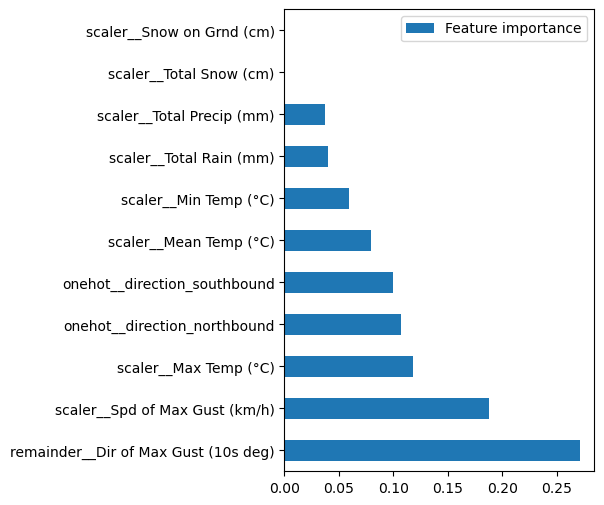

In [29]:
# Seeing which features are weighted most heavily by the model
def plot_feature_importances(model, figsize=(4,6)):
    importances = pd.DataFrame({'Feature importance': model.feature_importances_}, 
                           index=ct.get_feature_names_out()).sort_values(by='Feature importance',ascending=False)
    importances.plot.barh(figsize=figsize);

plot_feature_importances(model)

In [30]:
# Visiualizing one of the trees from the Random Forest
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ct.get_feature_names_out(),
                class_names = y_pred,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

### Exporting the Model

In [31]:
# exporting column transformer
ct_filename = 'commute_estimator_ct.pkl'
with open(ct_filename, 'wb') as file:
    pickle.dump(ct, file)

In [32]:
# exporting model
model_filename = 'commute_estimator_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)